## Setup Colab

In [1]:
from google.colab import drive 
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
wdir = '/content/gdrive/Othercomputers/My MacBook Air/cell-jamming/experiment_b'

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import bisect
from PIL import Image
np.set_printoptions(linewidth=np.inf)

## Creation of grid

In this experiment, a 8x20 grid is used for an original video of 454x1134 pixels.

In [4]:
# Discretization
m = 8
n = 20

# Volume
w = 454
h = 1134
n_frames = 29

# In the pixel space
disc_x = np.linspace(1, w, m+1)
disc_y = np.linspace(1, h, n+1)

The bisect function is adjusted such that the cells of the grid are indexed starting from 0.

In [5]:
# Boxes' indices are indexed starting from 0.
# Example: find_interval([1, 4, 7], 2) returns 0
def find_interval(interval, spot_pos):
  if spot_pos == interval[0]:
    return 0
  return bisect.bisect_left(interval, spot_pos) - 1

assert find_interval([0, 500, 1000, 1500], 0) == 0
assert find_interval([0, 500, 1000, 1500], 300) == 0
assert find_interval([0, 500, 1000, 1500], 500) == 0
assert find_interval([0, 500, 1000, 1500], 600) == 1
assert find_interval([0, 500, 1000, 1500], 1400) == 2
assert find_interval([0, 500, 1000, 1500], 1500) == 2

In [6]:
print(disc_x)
print(disc_y)

[  1.     57.625 114.25  170.875 227.5   284.125 340.75  397.375 454.   ]
[1.00000e+00 5.76500e+01 1.14300e+02 1.70950e+02 2.27600e+02 2.84250e+02 3.40900e+02 3.97550e+02 4.54200e+02 5.10850e+02 5.67500e+02 6.24150e+02 6.80800e+02 7.37450e+02 7.94100e+02 8.50750e+02 9.07400e+02 9.64050e+02 1.02070e+03 1.07735e+03 1.13400e+03]


## Read image

In [7]:
def read_tiff(path):
    img = Image.open(path)
    images = []
    for i in range(img.n_frames):
        img.seek(i)
        images.append(np.array(img))
    return np.array(images)

In [8]:
img = read_tiff(os.path.join(wdir, 'data_fiji/crop454_1134.tif'))

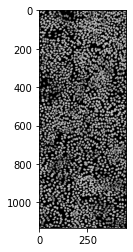

In [9]:
plt.imshow(img[0], cmap='gray', vmin=0, vmax=255)
plt.show()

## Create the csv file

In [10]:
folder_name = 'data_extracted' # For the original data
file_name = 'grid_data.csv' # For saving new data

In [11]:
X_coords = []
Y_coords = []
for i in range(0, len(disc_x)-1):
  delta = (disc_x[i+1]-disc_x[i])/2
  X_coords.append(disc_x[i]+delta)
for j in range(0, len(disc_y)-1):
  delta = (disc_y[j+1]-disc_y[j])/2
  Y_coords.append(disc_y[j]+delta)

In [12]:
with open(os.path.join(wdir, folder_name, file_name), 'w') as writefile:

  writefile.write("x,y,t,phi,N,u,vx,vy\n") # Header

  for t in range(0, n_frames):

    number_str = str(t).zfill(3)
    frame_file_name =  'frame' + number_str + '.csv'

    df = pd.read_csv(os.path.join(wdir, folder_name, frame_file_name)) # Data
    image = img[t] # Image

    # Transitory matrix with empty lists
    initial_matrix = np.empty((m,n),list) # For velocity, speed
    auxiliary_matrix = np.empty((m,n),list) # For packing fraction

    # Each list from the initial_matrix is of the form [x, y, t, phi, N, u, vx, vy].
    # Each list from the auxiliary_matrix is of the form [non_black_pixels, total_pixels].
    for j in range(0, n):
      for i in range(0, m):
        initial_matrix[i][j] = np.zeros(8)
        initial_matrix[i][j][0] = X_coords[i] # 0) x-coordinate
        initial_matrix[i][j][1] = Y_coords[j] # 1) y-coordinate
        initial_matrix[i][j][2] = t # 2) frame number
        auxiliary_matrix[i][j] = np.zeros(2)

    for j in range(0, h):
      for i in range(0, w):
        pixel_value = image[j,i]
        i_s = find_interval(disc_x, i+1)
        j_s = find_interval(disc_y, j+1)

        if pixel_value != 0:
          auxiliary_matrix[i_s][j_s][0] += 1 # Non-black pixels
        auxiliary_matrix[i_s][j_s][1] += 1 # Total pixels

    for j in range(0, n):
      for i in range(0, m):
        initial_matrix[i][j][3] = auxiliary_matrix[i][j][0] / auxiliary_matrix[i][j][1] # 3) packing fraction

    for index in range(0, len(df)):
      i_s = find_interval(disc_x, df['pos_x'][index])
      j_s = find_interval(disc_y, df['pos_y'][index])

      vx = df['vel_x'][index]
      vy = df['vel_y'][index]

      initial_matrix[i_s][j_s][4] += 1  # 4) number density
      initial_matrix[i_s][j_s][5] += np.sqrt(np.square(vx) + np.square(vy))  # 5) speed
      initial_matrix[i_s][j_s][6] += vx  # 6) x-velocity.
      initial_matrix[i_s][j_s][7] += vy  # 7) y-velocity.

    for j in range(0, n):
      for i in range(0, m):
        x = initial_matrix[i][j][0]
        y = initial_matrix[i][j][1]
        t = initial_matrix[i][j][2]
        phi = initial_matrix[i][j][3]
        N = initial_matrix[i][j][4]
        u_sum = initial_matrix[i][j][5]
        vx_sum = initial_matrix[i][j][6]
        vy_sum = initial_matrix[i][j][7]
        
        x, y, t, phi, N, u, vx, vy = x, y, t, phi, N, u_sum/N, vx_sum/N, vy_sum/N

        writefile.write(f"{x},{y},{t},{phi},{N},{u},{vx},{vy}\n")

## Testing...

Grid grows from top to bottom but image pixels grow from bottom to top.

In [ ]:
jaja = np.array([[0, 255, 255], [0, 255, 255], [0, 255, 100]])

In [ ]:
for j in range(0, 3):
  for i in range(0, 3):
    pixel_value = jaja[i,j]
    print(pixel_value)

0
0
0
255
255
255
255
255
100


In [ ]:
disc_x

array([   0.        ,   59.68421053,  119.36842105,  179.05263158,  238.73684211,  298.42105263,  358.10526316,  417.78947368,  477.47368421,  537.15789474,  596.84210526,  656.52631579,  716.21052632,  775.89473684,  835.57894737,  895.26315789,  954.94736842, 1014.63157895, 1074.31578947, 1134.        ])

In [ ]:
jaja = np.array([[0,0,0,0],[0,0,255,0],[255,255,255,255],[0,0,0,255]])

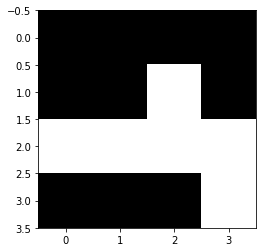

In [ ]:
plt.imshow(jaja, cmap='gray', vmin=0, vmax=255)
plt.show()

In [ ]:
# Discretization
m = 2
n = 2

# Volume
w = 4
h = 4
n_frames = 1

# In the pixel space
disc_x = np.linspace(1, w, m+1)
disc_y = np.linspace(1, h, n+1)

In [ ]:
disc_x

array([1. , 2.5, 4. ])

In [ ]:
auxiliary_matrix = np.empty((m,n),list) # For packing fraction

    # Each list from the initial_matrix is of the form [x, y, t, phi, N, u, vx, vy].
    # Each list from the auxiliary_matrix is of the form [non_black_pixels, total_pixels].
for j in range(0, n):
  for i in range(0, m):
      auxiliary_matrix[i][j] = np.zeros(2)

for j in range(0, h):
  for i in range(0, w):
      pixel_value = jaja[i,j]
      i_s = find_interval(disc_x, i+1)
      j_s = find_interval(disc_y, j+1)

      if pixel_value != 0:
        auxiliary_matrix[i_s][j_s][0] += 1 # Non-black pixels
      auxiliary_matrix[i_s][j_s][1] += 1 # Total pixels
    
print(auxiliary_matrix)

[[array([0., 4.]) array([1., 4.])]
 [array([2., 4.]) array([3., 4.])]]


In [ ]:
initial_matrix = np.empty((m,n),list)

In [ ]:
for j in range(0, n):
  for i in range(0, m):
    initial_matrix[i][j] = auxiliary_matrix[i][j][0] / auxiliary_matrix[i][j][1] # 3) packing fraction

In [ ]:
initial_matrix

array([[0.0, 0.25],
       [0.5, 0.75]], dtype=object)